# Recurrent Neural Networks and image synthesis

There are several ways to show various properties of recurrent neural networks but image synthesis offers most visually evident demonstrations. 

**Note:** Make sure that Python Imaging Library or its friendly fork Pillow is installed or otherwise you get strange errors.

In [4]:
import tqdm
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

## I. Challenge images

To make our life easier we are considering two vertically striped images challenge problems: 
* The first is Muhu skirt pattern that is clearly periodical.
* The second is picture of grass which is very close to a striped pattern.

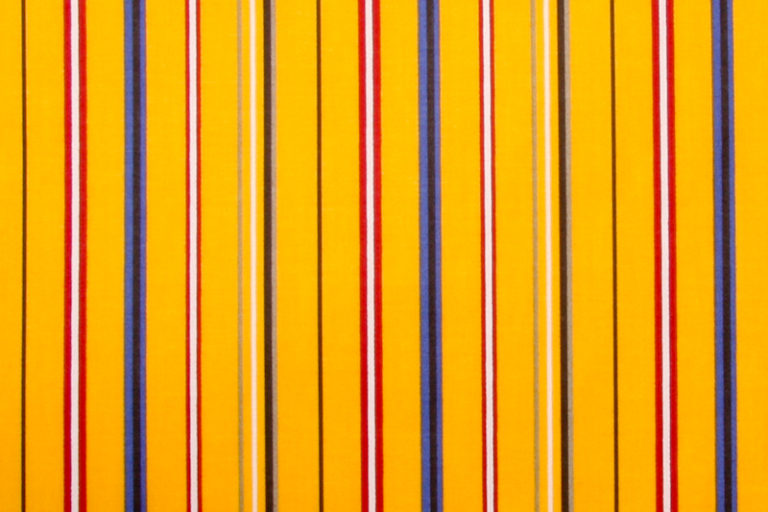

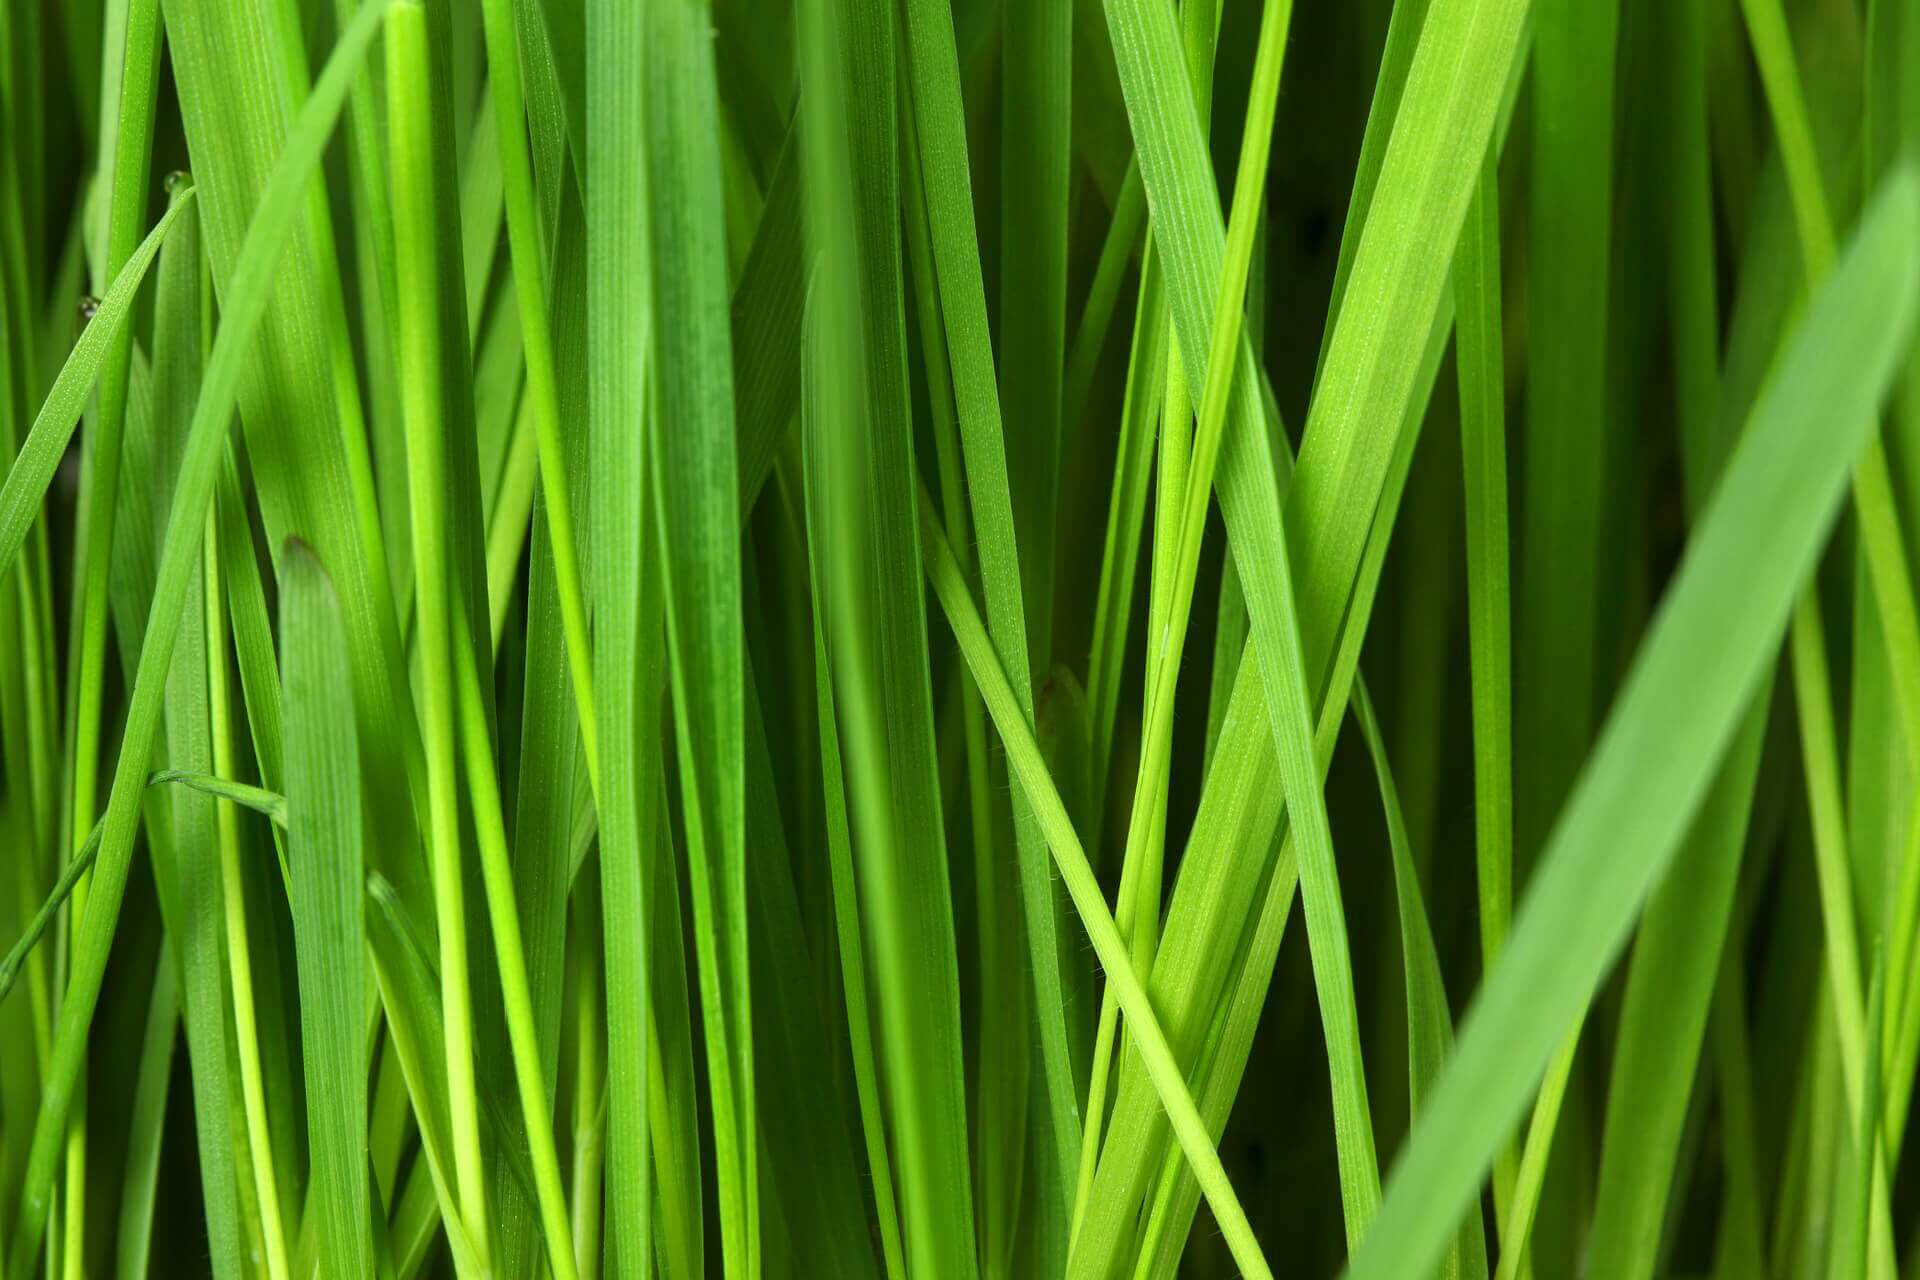

In [2]:
stripes = tf.keras.utils.load_img('data/muhu_pattern.jpg')
grass = tf.keras.utils.load_img('data/grass.jpg')
display(stripes)
display(grass)

For simplicity we are working mostly on the greyscaled versions of these images.

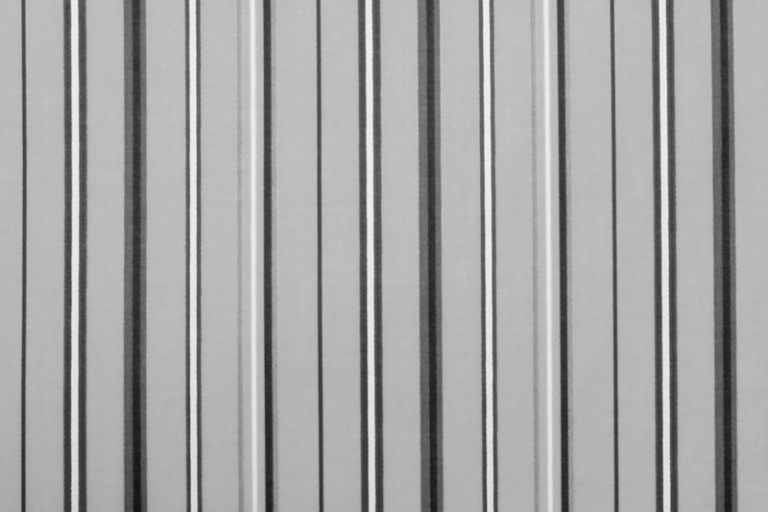

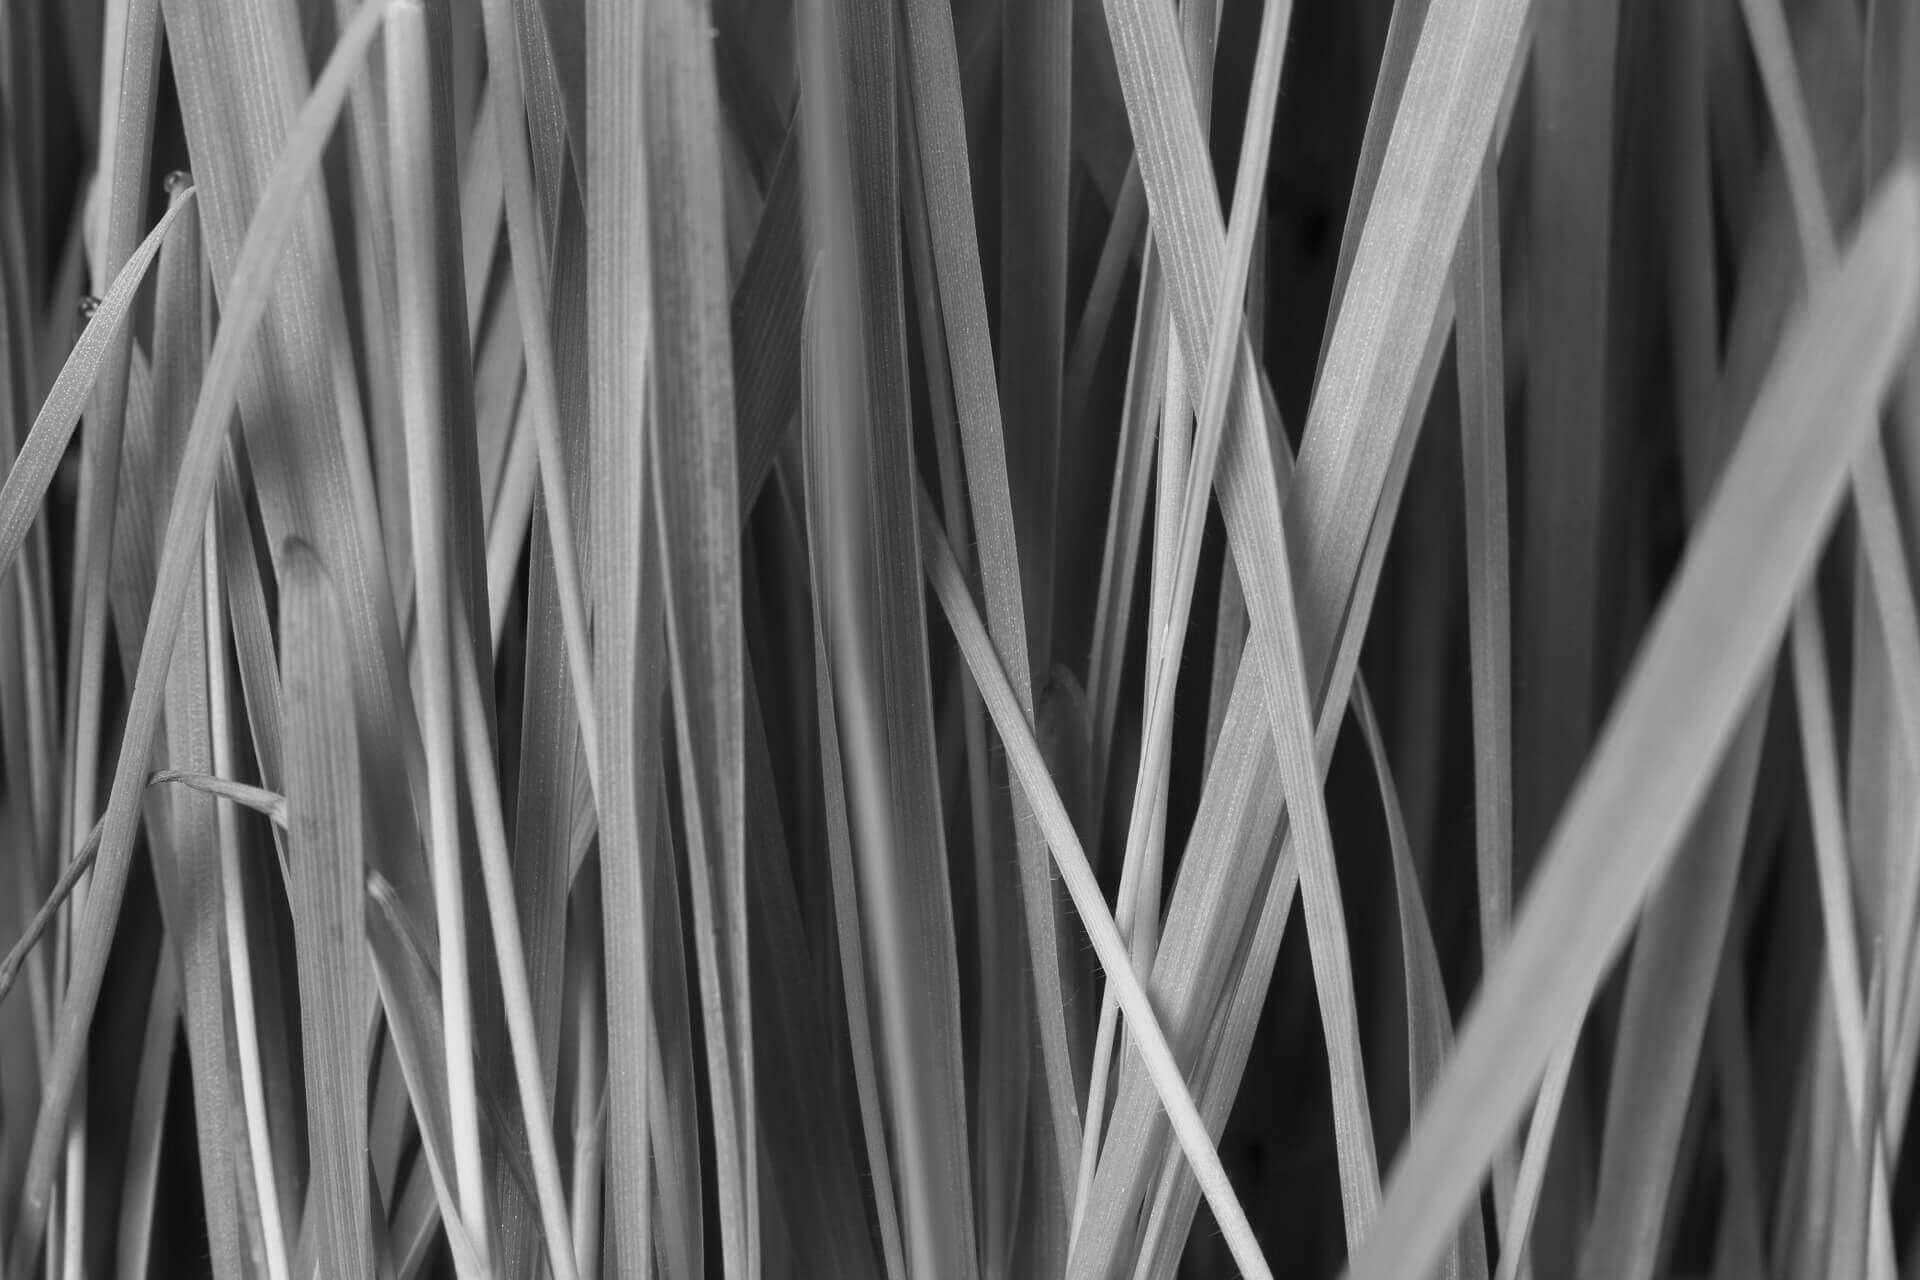

In [3]:
stripes_bw = tf.keras.utils.load_img('data/muhu_pattern.jpg', color_mode='grayscale')
grass_bw = tf.keras.utils.load_img('data/grass.jpg', color_mode='grayscale')
display(stripes_bw)
display(grass_bw)

## II. Prediction with fixed lag-structure

Before using recurrent neural networks we can consider models with finite locahead to past, i.e., we are going to predict

\begin{align*}
x_i=f(x_{i-1}, x_{i-2}, \ldots, x_{i-d})
\end{align*}

In order to be successful we need to correctly guess the minimal lag $d$ that is needed to predict the value $x_i$. A good guess to $d$ is very important as too small $d$ hides crucial information and too large $d$ inflates the number of model parameters and we might overfit the model.  

### From image to sequence

Image as a two-dimensional object is not sequence but there are several ways to convert it into sequence or set of sequences. 

* As our images are vertically striped we can consider each row as a separate sequence. 
* This simplifies our prediction task but makes prediction of different rows independent and this obviously creates mismatches. 


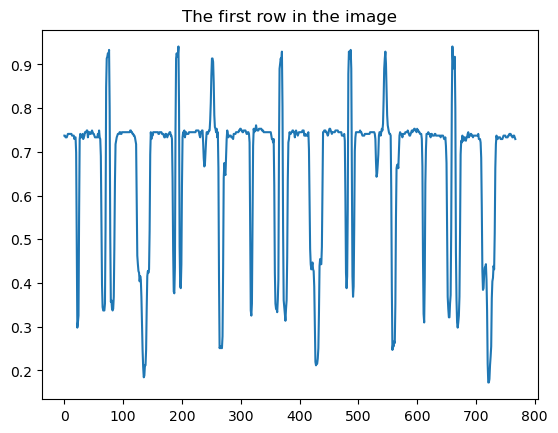

In [4]:
data = tf.keras.preprocessing.image.img_to_array(stripes_bw)/255.0

plt.plot(data[0, : , 0])
plt.title("The first row in the image")
plt.show()

### Data shaping 

To follow the logic of Tensorflow we will create a three-dimensional tensor where the last dimension contains time-shifted data $x_{i-1},\ldots, x_{i-d}$ as prediction data $X$ and the original two-dimensional tensor containing the next value for prediction $x_i$.  

Later on we flatten the tensors into two-dimensional data where the second dimension iterates over $x_{i-1},\ldots, x_{i-d}$ and one-dimensional target. This requires a lot of brain-power to fix right flattening order.
After that we are ready to fit neural network models on the data. 

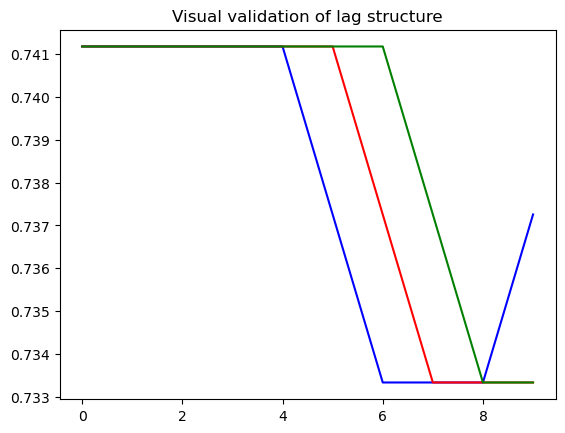

In [5]:
d=10
m, n = data[:, :, 0].shape

# Initial tensors
y = tf.convert_to_tensor(data[:, d + 1:, 0])
x = tf.stack([data[:, j:(n - d - 1 + j), 0] for j in range(d, 0, -1)], axis=2)

# Visual validation
plt.plot(x[0, 0, :], color='blue')
plt.plot(x[0, 1, :], color='red')
plt.plot(x[0, 2, :], color='green')
plt.title('Visual validation of lag structure')
plt.show()

# Test values
x_00 = x[0, 0, :]
x_01 = x[0, 1, :]
x_10 = x[1, 0, :]

# Reshaped tensors
y = tf.reshape(y, tf.size(y))
x = tf.reshape(x, (x.shape[0] * x.shape[1], x.shape[2]))

# Sanity check on reshape
assert all(tf.equal(x[0,  :], x_00))
assert all(tf.equal(x[1,  :], x_01))
assert all(tf.equal(x[n - 1 - d,:], x_10))

### Simple linear regression

We can now build a linear regression model for the lag $d=10$ using keras.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (387584, 1)               11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12112/12112 [==============================] - 4s 321us/step - loss: 0.0417 - mse: 0.0417
Epoch 2/10
12112/12112 [==============================] - 4s 310us/step - loss: 0.0021 - mse: 0.0021
Epoch 3/10
12112/12112 [==============================] - 4s 314us/step - loss: 0.0018 - mse: 0.0018
Epoch 4/10
12112/12112 [==============================] - 4s 300us/step - loss: 0.0017 - mse: 0.0017
Epoch 5/10
12112/12112 [==============================] - 4s 301us/step - loss: 0.0017 - mse: 0.0017
Epoch 6/10
12112/12112 [==============================] - 4s 304us/step - loss: 0

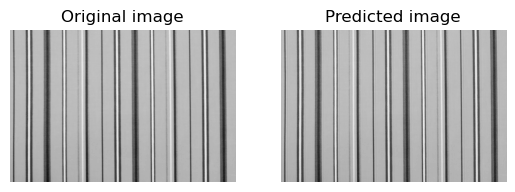

In [10]:
# Build a simple model
lr_model = Sequential()
lr_model.add(Dense(1, activation='linear'))
lr_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
lr_model.build(input_shape=x.shape)
lr_model.summary()

# Make one-step predictions 
lr_model.fit(x, y, epochs=10)

yhat = tf.reshape(lr_model.predict(x), (m , (n-d-1)))

# Visual comparison between predictions and original
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(tf.reshape(y, (m, n-d-1)), cmap='gray', vmin=0, vmax=1)
ax1.set_title('Original image')
ax1.axis('off')
ax2.imshow(yhat, cmap='gray', vmin=0, vmax=1)
ax2.set_title('Predicted image')
ax2.axis('off')
plt.show()

As you can see the next pixel prediction is quite good.
However, the model is not suitable for multi-step prediction (synthesizing large patches).
Also note that the tensor manipulation for multi-step prediction is quite envolved as can be seen from the first prediction step. 

16/16 [==============================] - 0s 420us/step


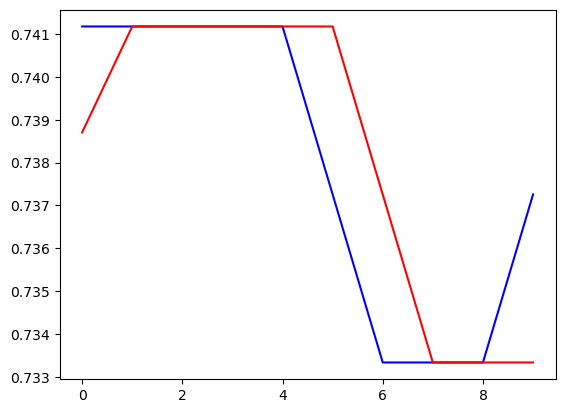

In [75]:
# Visual validation of single lag update step
lag = tf.gather(x, [i * (n-1-d) for i in range(m)], axis=0)
yhat = lr_model.predict(lag)
new_lag = tf.concat([yhat, lag[:, :d-1]], axis=1)

plt.plot(lag[0, :], color='blue')
plt.plot(new_lag[0, :], color='red')
plt.show()

100%|█████████████████████████████████████████████████| 757/757 [00:12<00:00, 60.49it/s]


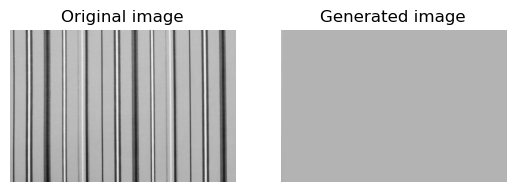

In [122]:
# Multistep prediction for the entire image
lag = tf.gather(x, [i * (n-1-d) for i in range(m)], axis=0)
yhat = tf.fill((m, 0), np.nan)

for i in tqdm.trange(n-1-d):
    yhat = tf.concat([yhat, lr_model.predict(lag, verbose=0)], axis=1) 
    lag = tf.concat([yhat[:, i:i+1], lag[:, :d-1]], axis=1)

# Visual comparison between predictions and original
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(tf.reshape(y, (m, n-d-1)), cmap='gray', vmin=0, vmax=1)
ax1.set_title('Original image')
ax1.axis('off')
ax2.imshow(yhat, cmap='gray', vmin=0, vmax=1)
ax2.set_title('Generated image')
ax2.axis('off')
plt.show()

**Clarification** 
* This kind of behaviour is expected as the best way to predict nect pixel is to use the average of previous pixels.
* This kind of behaviour completely disregards long-term patterns in the sequence.

In [ ]:
weights, bias = lr_model.layers[0].get_weights()
plt.bar(list(range(10)),  weights.flatten())
plt.title(f'Weights of the linear model with a near-zero bias term {bias[0]:.3f}')
plt.show()

## III. Plain recurrent neural network with RELU

## IV. Standard LTSM network

In [8]:
?tf.keras.Input

In [10]:
?tf.keras.layers.LSTM

In [ ]:
lstm_model = Model 

In [5]:
?Model

In [ ]:
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = layers.LSTM(units=10)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [6]:
?tf.keras.layers.LSTM

## V. Combining rows and columns with LSTM  